# ЛР 2. Сравнение разных типов индекса с Faiss

# Эталонное сравнение

In [2]:
import opendatasets as od
import pandas
import numpy as np
import json
from heapq import heappop, heappush,heappushpop
import matplotlib.pyplot as plt

import time
od.download(
	"https://www.kaggle.com/datasets/zalando-research/fashionmnist/data")

100%|████████████████████████████████████████████████████████████████████████████████| 68.8M/68.8M [00:06<00:00, 10.5MB/s]


In [20]:
def distance(a, b):
    temp = a - b
    return np.sqrt(sum(temp**2))

# Fixed size priority queue (max heap) realization
# h - reversed array, so actual answer will be -h.
# k - size of priority queue
def push(h, distance, index, k):
    item = (-1 * distance, index)
    if (len(h) < k):
        heappush(h, item)
    else:
        heappushpop(h, item)
    
# Return k nearest vectors for given vector from ds.
# D - array with distances, I - array with indexes.
def get_nearest(k, vector, ds):
    h = []
    for i in range(len(vectors)):
        push(h, distance(vector, ds.iloc[i]), i, k)
    # Distances in ascending order 
    h.sort(reverse=True)
    D = []
    I = []
    for i in range(len(h)):
    # Reverse distance value to make it normal (it was reversed in push for max heap realization)
        D.append(-h[i][0])
        I.append(h[i][1])
    return (D, I)

def write_in_json(ind_to_find, D, I, k, filename):
    to_write = {
        "k": k,
        "ind_to_find": ind_to_find,
        "distances": D,
        "indexes": I
    }
    with open(filename, "w") as outfile:
        json.dump(to_write, outfile)

def find_nearest(k, ind_to_find, vectors, exp_name):
    print(f"{exp_name}: k = {k}, index_to_find = {ind_to_find}")
    D, I = get_nearest(k, vectors.iloc[ind_to_find], vectors)
    write_in_json(ind_to_find, D, I, k, "experiments/" + exp_name + '.json')

In [21]:
mnist = pandas.read_csv("./fashionmnist/fashion-mnist_train.csv")
vectors = mnist.drop(columns='label')

In [22]:
indexes_to_find = [10, 50, 100, 1000, 2000, 3000, 4000, 10000, 20000]

In [24]:
k = 16
# Мерим время вместе с записью результатов в json, 
# но время записи не существенно (поскольку сам поиск занимает больше 6 секунд)
for ind in indexes_to_find:
    %time find_nearest(k, ind, vectors, 'exp' + str(ind))    

exp10: k = 16, index_to_find = 10
CPU times: user 6.65 s, sys: 11.3 ms, total: 6.66 s
Wall time: 6.74 s
exp50: k = 16, index_to_find = 50
CPU times: user 6.59 s, sys: 7.21 ms, total: 6.59 s
Wall time: 6.65 s
exp100: k = 16, index_to_find = 100
CPU times: user 6.7 s, sys: 4.18 ms, total: 6.7 s
Wall time: 6.76 s
exp1000: k = 16, index_to_find = 1000
CPU times: user 6.58 s, sys: 6.53 ms, total: 6.59 s
Wall time: 6.66 s
exp2000: k = 16, index_to_find = 2000
CPU times: user 6.68 s, sys: 9.93 ms, total: 6.69 s
Wall time: 6.74 s
exp3000: k = 16, index_to_find = 3000
CPU times: user 6.63 s, sys: 4.15 ms, total: 6.64 s
Wall time: 6.69 s
exp4000: k = 16, index_to_find = 4000
CPU times: user 6.63 s, sys: 8.73 ms, total: 6.64 s
Wall time: 6.7 s
exp10000: k = 16, index_to_find = 10000
CPU times: user 6.68 s, sys: 9.12 ms, total: 6.69 s
Wall time: 6.75 s
exp20000: k = 16, index_to_find = 20000
CPU times: user 6.61 s, sys: 4.82 ms, total: 6.61 s
Wall time: 6.65 s


# Faiss

In [138]:
# https://faiss.ai/index.html
# conda install -c conda-forge faiss-cpu
# https://github.com/facebookresearch/faiss/wiki/Faiss-indexes - типы индексов 

In [59]:
def compare_with_ideal(I_ideal, I, indexes_to_find, k):
    # Посчитаем точность
    sum_accuracy = 0
    for i in range(len(indexes_to_find)):
        matched = set(I_ideal[i]).intersection(set(I[i]))
        accuracy = len(matched) / k
        # print(f'find nearest with {indexes_to_find[i]}, accuracy: {len(matched) / k}')
        sum_accuracy += accuracy
    avg_accuracy = sum_accuracy / len(indexes_to_find)
    # print(f'avg accuracy: {sum_accuracy / len(indexes_to_find)}')

    return avg_accuracy

In [27]:
import numpy as np
import faiss                  # make faiss available

mnist = pandas.read_csv("./fashionmnist/fashion-mnist_train.csv")
vectors = mnist.drop(columns='label')
d = vectors.shape[1]
k = 16

index_basic = faiss.IndexFlatL2(d)   # build the index
print(index_basic.is_trained)
index_basic.add(vectors)
print(index_basic.ntotal)


True
60000


In [28]:
indexes_to_find = [10, 50, 100, 1000, 2000, 3000, 4000, 10000, 20000]

print(f'indexes for which we find neighbors: {indexes}')
%time D_ideal, I_ideal = index_basic.search(vectors.iloc[indexes], k)

indexes for which we find neighbors: [10, 50, 100, 1000, 2000, 3000, 4000, 10000, 20000]
CPU times: user 91 ms, sys: 44.3 ms, total: 135 ms
Wall time: 17.6 ms


# Inverted file index
Разбиение на кластеры и пересчет внутри кластера.

In [29]:
def create_ivf_index(clusters_count, d, vectors):
    quantiser = faiss.IndexFlatL2(d)
    index_ivf = faiss.IndexIVFFlat(quantiser, d, clusters_count)
    index_ivf.train(vectors) 
    index_ivf.add(vectors)
    return index_ivf

In [30]:
clusters_n_arr = [5, 10, 50, 100, 200, 350, 500, 1000, 2000]
accuracy_arr = []
time_create_index_ms = [] 
time_search_ms = []
for clusters_count in clusters_n_arr:
    print(f'ivf with clusters count {clusters_count}')
    
    start = time.perf_counter_ns()
    ivf = create_ivf_index(clusters_count, d, vectors)
    time_create_index_ms.append((time.perf_counter_ns() - start) / 1e6)

    start = time.perf_counter_ns()
    D, I = ivf.search(vectors.iloc[indexes_to_find], k)
    time_search_ms.append((time.perf_counter_ns() - start) / 1e6)

    accur = compare_with_ideal(I_ideal, I, indexes_to_find, k)
    accuracy_arr.append(accur)
    print()



ivf with clusters count 5
find nearest with 10, accuracy: 1.0
find nearest with 50, accuracy: 1.0
find nearest with 100, accuracy: 1.0
find nearest with 1000, accuracy: 1.0
find nearest with 2000, accuracy: 0.625
find nearest with 3000, accuracy: 1.0
find nearest with 4000, accuracy: 1.0
find nearest with 10000, accuracy: 0.875
find nearest with 20000, accuracy: 1.0
avg accuracy: 0.9444444444444444

ivf with clusters count 10
find nearest with 10, accuracy: 1.0
find nearest with 50, accuracy: 0.875
find nearest with 100, accuracy: 1.0
find nearest with 1000, accuracy: 0.375
find nearest with 2000, accuracy: 1.0
find nearest with 3000, accuracy: 1.0
find nearest with 4000, accuracy: 1.0
find nearest with 10000, accuracy: 0.875
find nearest with 20000, accuracy: 1.0
avg accuracy: 0.9027777777777778

ivf with clusters count 50
find nearest with 10, accuracy: 1.0
find nearest with 50, accuracy: 0.4375
find nearest with 100, accuracy: 0.75
find nearest with 1000, accuracy: 0.1875
find neare

WARNING clustering 60000 points to 2000 centroids: please provide at least 78000 training points


find nearest with 10, accuracy: 0.75
find nearest with 50, accuracy: 0.25
find nearest with 100, accuracy: 0.4375
find nearest with 1000, accuracy: 0.8125
find nearest with 2000, accuracy: 0.9375
find nearest with 3000, accuracy: 0.5
find nearest with 4000, accuracy: 0.25
find nearest with 10000, accuracy: 0.3125
find nearest with 20000, accuracy: 0.4375
avg accuracy: 0.5208333333333334



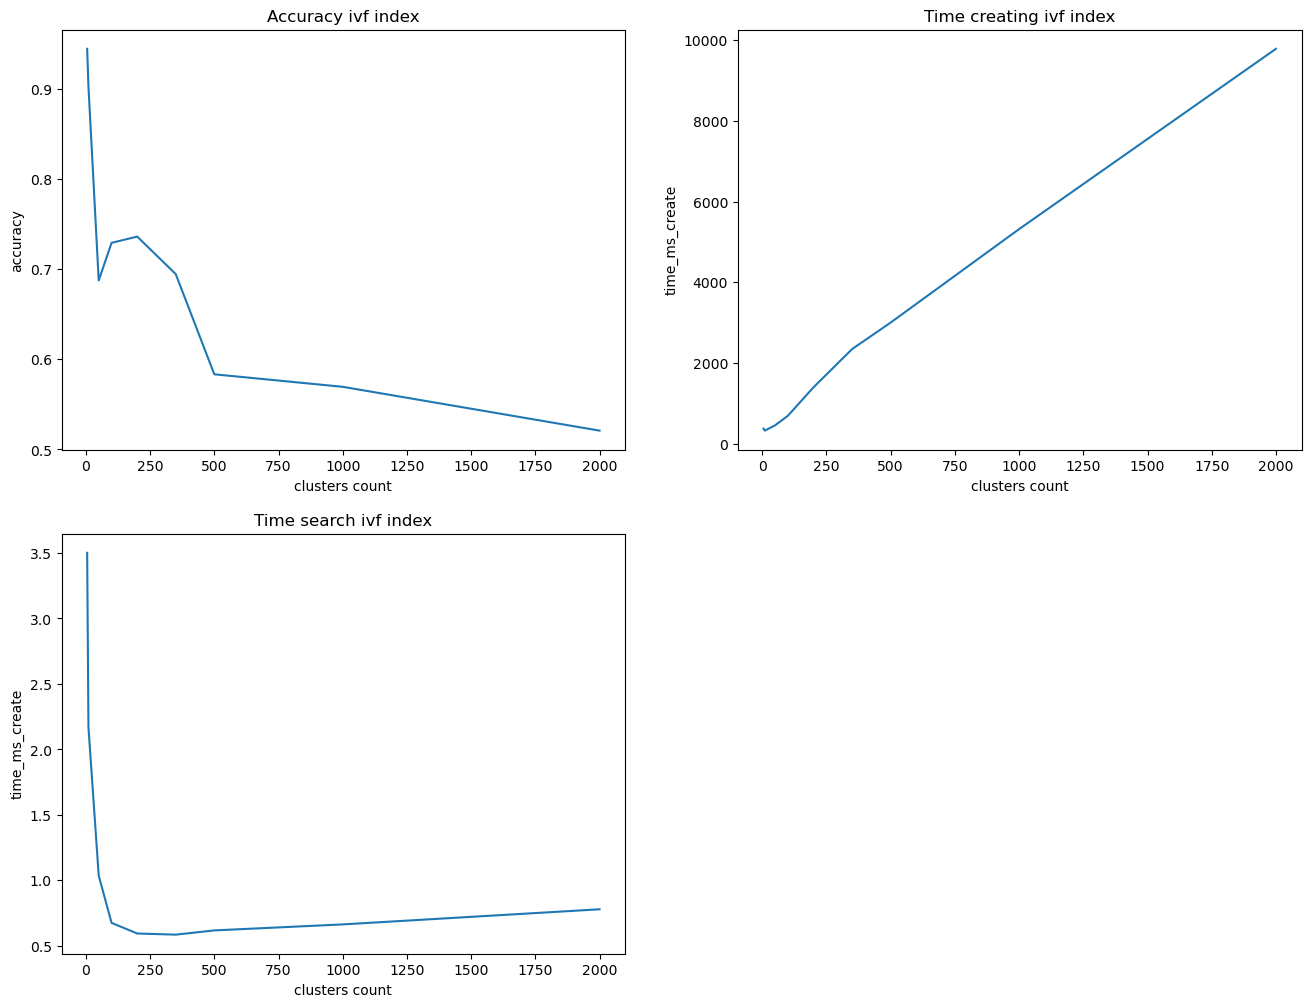

In [41]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.plot(clusters_n_arr, accuracy_arr)
plt.xlabel('clusters count')
plt.ylabel('accuracy')
plt.title('Accuracy ivf index')

plt.subplot(2, 2, 2)
plt.plot(clusters_n_arr, time_create_index_ms)
plt.xlabel('clusters count')
plt.ylabel('time_ms')
plt.title('Time creating ivf index')

plt.subplot(2, 2, 3)
plt.plot(clusters_n_arr, time_search_ms)
plt.xlabel('clusters count')
plt.ylabel('time_ms')
plt.title('Time search ivf index')

plt.show()

## IVF Итог:
Чем больше кластеров, тем выше точность поскольку внутри кластера мы честно пересчитываем расстояния

Однако время поиска при малом количестве кластеров большое, что тоже объясняется честным пересчетом расстояний внутри кластера. Чем меньше кластеров, тем больше векторов внутри кластера и тем больше расстояний надо обсчитать.

# HNSW
Hierarchical Navigable Small World graph exploration.

In [51]:
# M - number of connections each vertex will have
# ef_search - depth of layers explored during search
# ef_construction = 64 - depth of layers explored during index construction
def create_hnsw_index(vectors, M=64, ef_search=32, ef_construction=64):
    # initialize index (d == 128)
    index = faiss.IndexHNSWFlat(d, M)
    # set efConstruction and efSearch parameters
    index.hnsw.efConstruction = ef_construction
    index.hnsw.efSearch = ef_search
    # add data to index
    index.add(vectors)
    return index

In [74]:
def plot_graphics(M_arr, accuracy_arr, time_create_index_ms, time_search_ms, plt, label):
    # plt.title(f'Stats for hnsw with ef_search{title}')
    
    plt.subplot(2, 2, 1)
    plt.plot(M_arr, time_create_index_ms, label=label)
    plt.xlabel('M')
    plt.ylabel('time_ms')
    plt.title('Time creating index')
    
    plt.subplot(2, 2, 3)
    plt.plot(M_arr, accuracy_arr, label=label)
    plt.xlabel('M')
    plt.ylabel('accuracy')
    plt.title('Accuracy')

    plt.subplot(2, 2, 4)
    plt.plot(M_arr, time_search_ms, label=label)
    plt.xlabel('M')
    plt.ylabel('time_ms')
    plt.title('Time search')


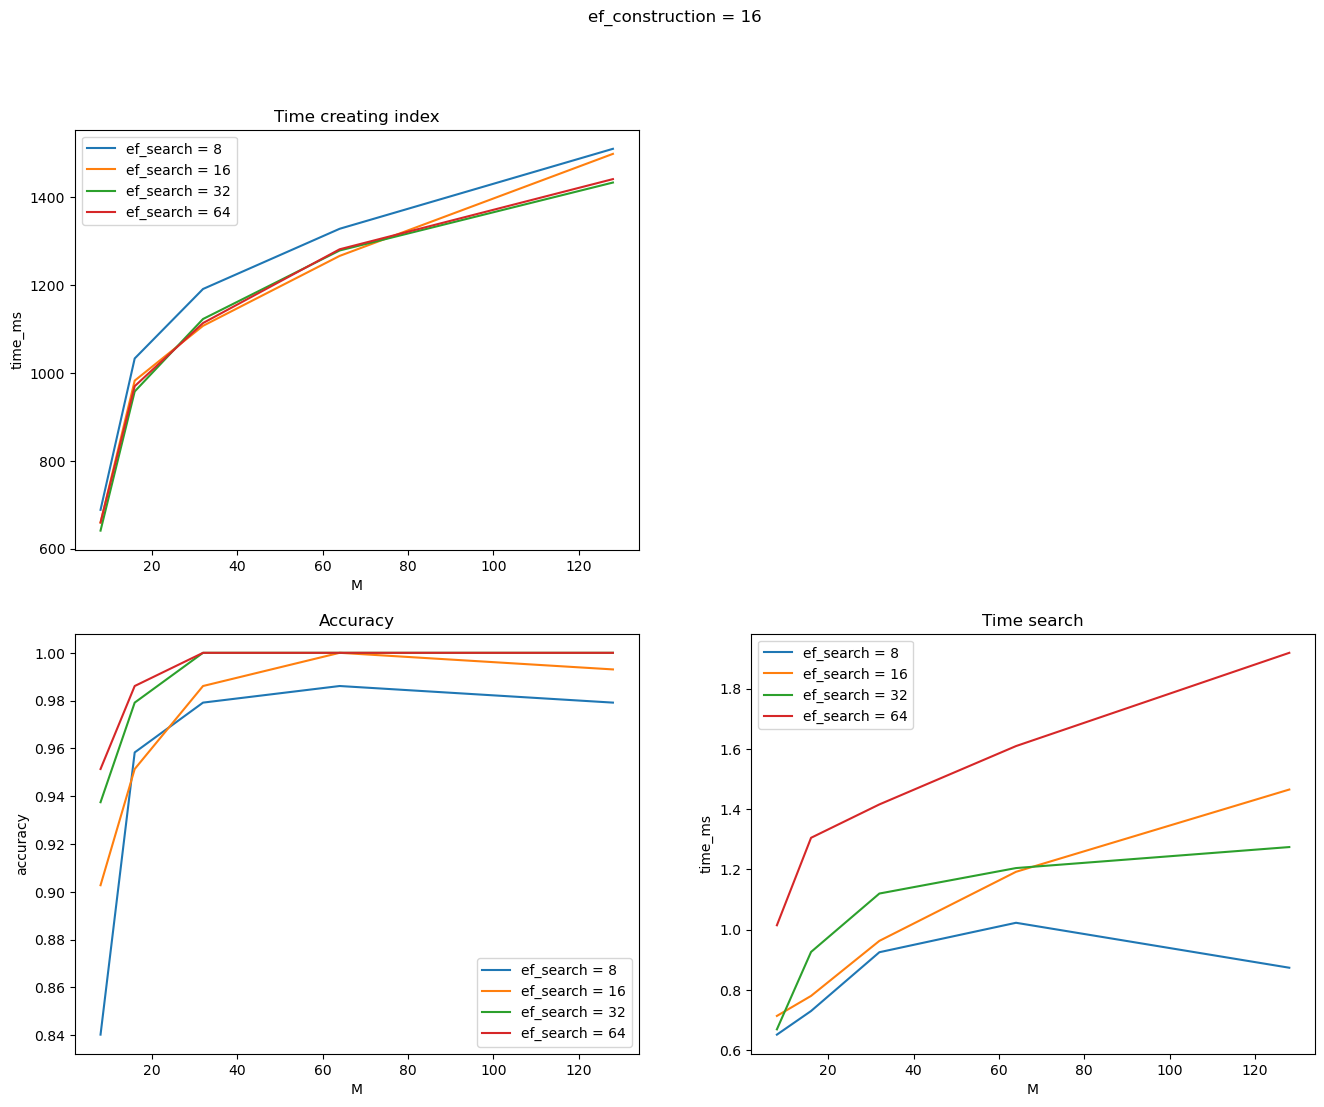

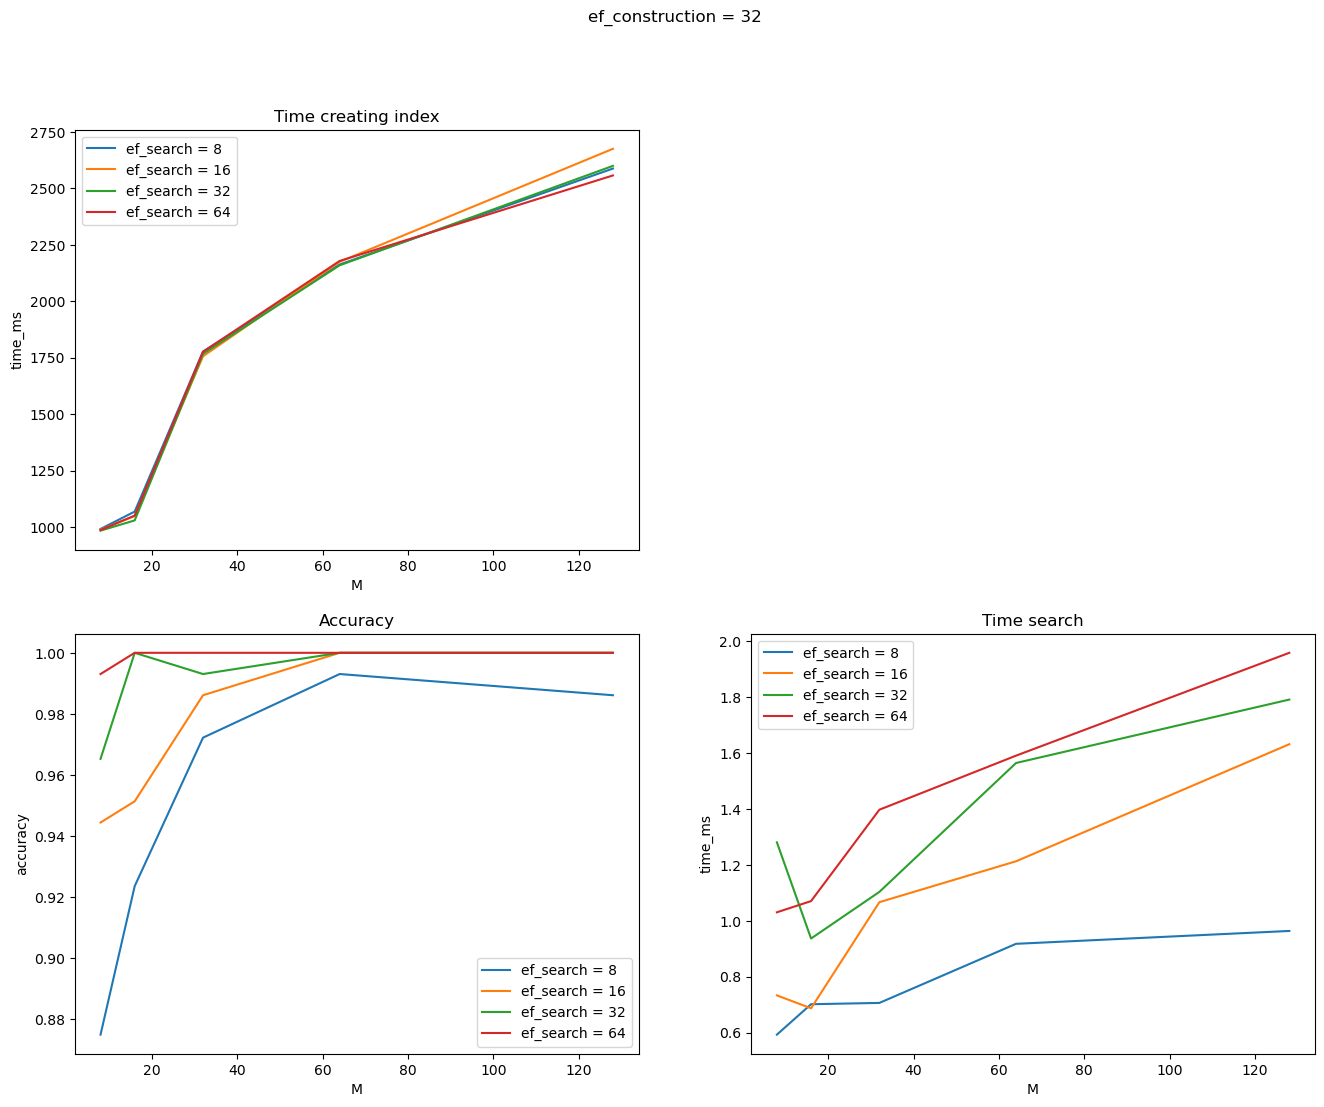

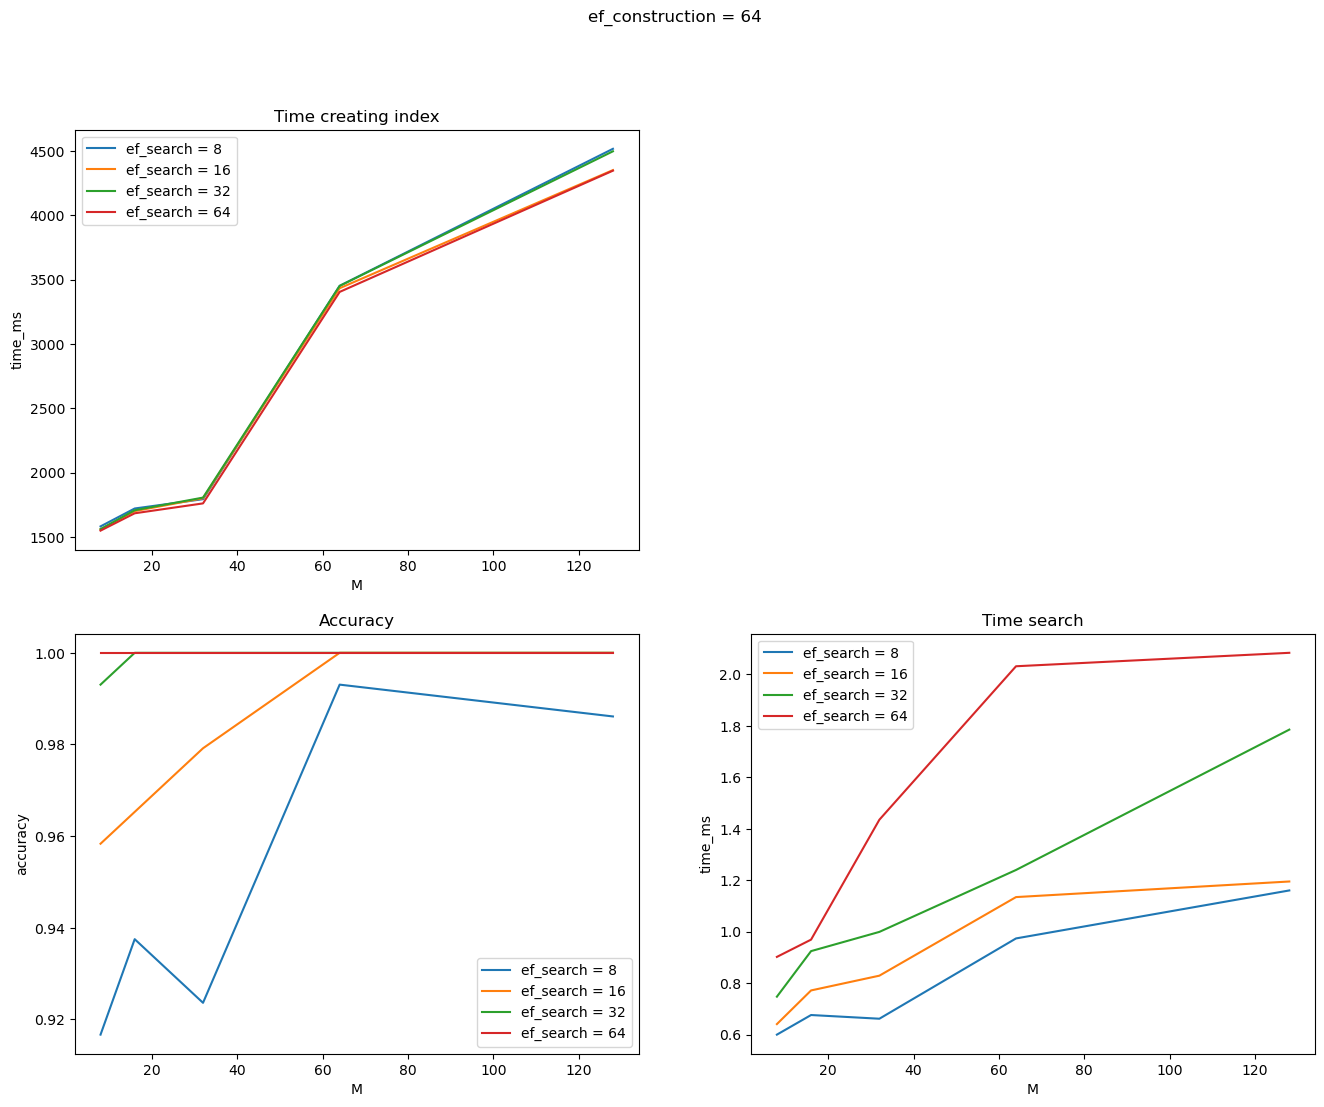

In [75]:
M_arr = [8, 16, 32, 64, 128]
ef_search_arr = [8, 16, 32, 64]
ef_construction_arr = [16, 32, 64]

for ef_construction in ef_construction_arr: 
    plt.figure(figsize=(16, 12))
    pp = plt
    for ef_search in ef_search_arr:
        accuracy_arr = []
        time_create_index_ms = [] 
        time_search_ms = []
        for M in M_arr:            
            start = time.perf_counter_ns()
            hnsw = create_hnsw_index(vectors, M=M, ef_search=ef_search, ef_construction=ef_construction)
            time_create_index_ms.append((time.perf_counter_ns() - start) / 1e6)
        
            start = time.perf_counter_ns()
            D, I = hnsw.search(vectors.iloc[indexes_to_find], k)
            time_search_ms.append((time.perf_counter_ns() - start) / 1e6)
        
            accur = compare_with_ideal(I_ideal, I, indexes_to_find, k)
            accuracy_arr.append(accur)
            # print()
        plot_graphics(M_arr, accuracy_arr, time_create_index_ms, time_search_ms, pp, f'ef_search = {ef_search}') 
    # pp.title('ef_search = {ef_search}')
    
    
    pp.suptitle(f'ef_construction = {ef_construction}')

    pp.subplot(2, 2, 1)
    pp.legend()
    pp.subplot(2, 2, 3)
    pp.legend()
    pp.subplot(2, 2, 4)
    pp.legend()

    pp.show()

* M - количество ребер у каждой вершины
* ef_search - глубина исследования во время поиска
* ef_construction - глубина исследования во время построения


## HNSW итог:
* Чем больше ребер (M), тем дольше построения индекса и поиск, но при этом выше точность
* Чем больше глубина исследования во время поиска, тем выше точность, но дольше поиск
* Чем больше глубина исследования во время построения, тем выше точность, но дольше построение индекса

# LSH

In [79]:
def create_lsh_index(num_bits, d, vectors):
    index_lsh = faiss.IndexLSH(d, num_bits)
    index_lsh.train(vectors) 
    index_lsh.add(vectors)
    return index_lsh

NOTE: The algorithm is not vanilla-LSH, but a better choice. Instead of set of orthogonal projectors is used if n_bits <= d, or a tight frame if n_bits > d.

In [81]:
d

784

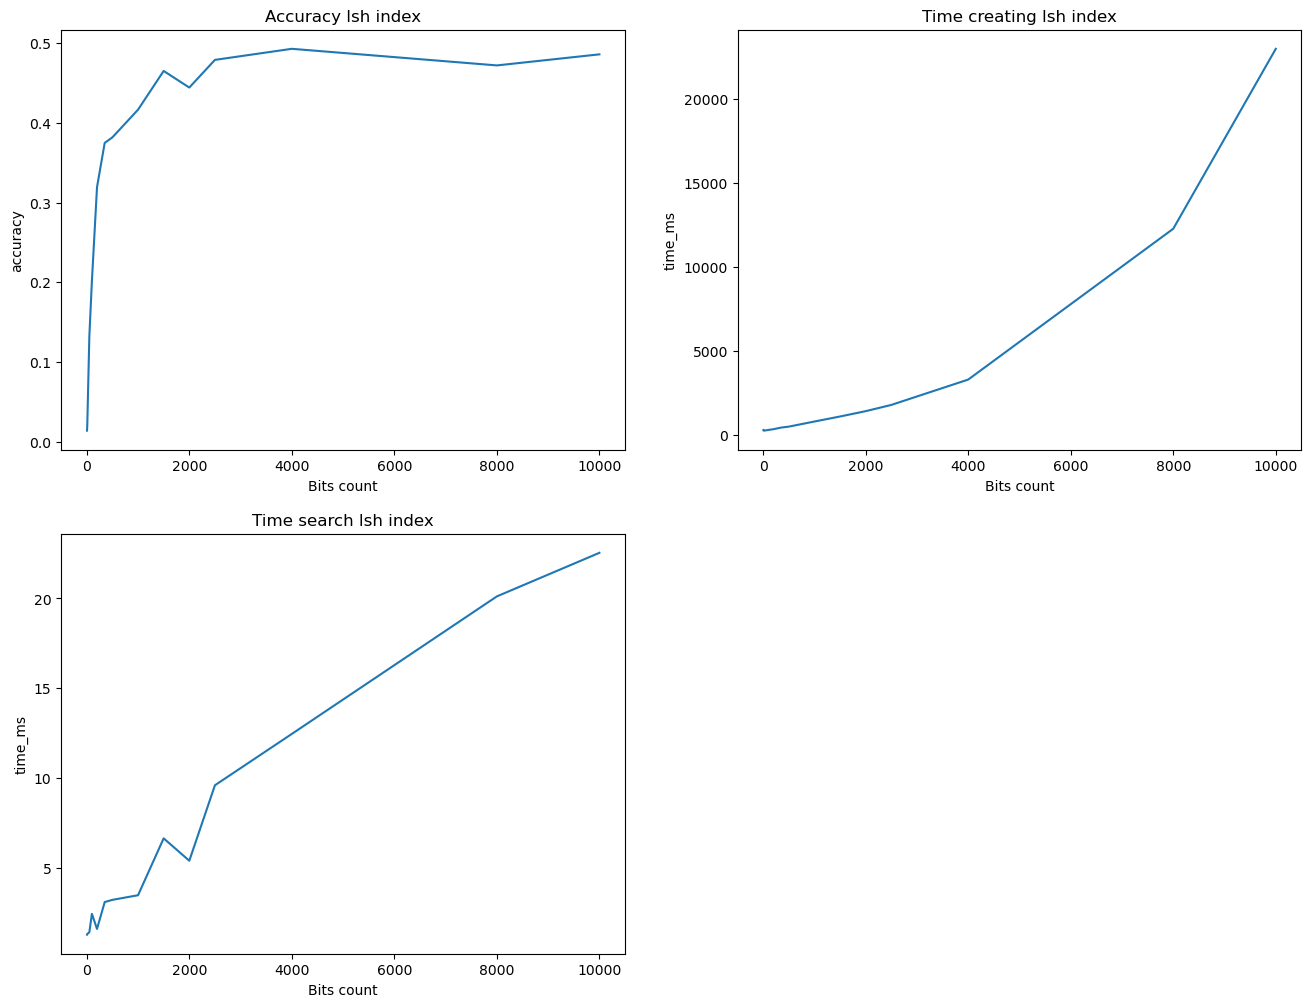

In [86]:
n_bits_arr = [5, 10, 50, 100, 200, 350, 500, 1000, 1500, 2000, 2500, 4000, 8000, 10000]
accuracy_arr = []
time_create_index_ms = [] 
time_search_ms = []
for n_bits in n_bits_arr:    
    start = time.perf_counter_ns()
    lsh = create_lsh_index(n_bits, d, vectors)
    time_create_index_ms.append((time.perf_counter_ns() - start) / 1e6)

    start = time.perf_counter_ns()
    D, I = lsh.search(vectors.iloc[indexes_to_find], k)
    time_search_ms.append((time.perf_counter_ns() - start) / 1e6)

    accur = compare_with_ideal(I_ideal, I, indexes_to_find, k)
    accuracy_arr.append(accur)

plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.plot(n_bits_arr, accuracy_arr)
plt.xlabel('Bits count')
plt.ylabel('accuracy')
plt.title('Accuracy lsh index')

plt.subplot(2, 2, 2)
plt.plot(n_bits_arr, time_create_index_ms)
plt.xlabel('Bits count')
plt.ylabel('time_ms')
plt.title('Time creating lsh index')

plt.subplot(2, 2, 3)
plt.plot(n_bits_arr, time_search_ms)
plt.xlabel('Bits count')
plt.ylabel('time_ms')
plt.title('Time search lsh index')

plt.show()

# LSH: Итоги
* LSH сильно проигрывает другим алгоритмам по точности, плато в 0.5 accuracy
* По скорости поиска тоже проигрывает
* Зато выигрывает по памяти

| Alghorithm | Memory (bytes/vector) |
| ---------- | --------------------- |
| FLAT       | 4 * d                 |
| IVF        | 4 * d + 8             |
| HNSW       | 4*d + x * M * 2 * 4   |
| LSH        | ceil(nbits/8)         |

# Итог
* HNSW самый точный и быстрый (при чем как по построению, так и по поиску), но нужно много памяти
* IVF работает медленее и не так точно, как HNSW, но зато потребляет меньше памяти
* LSH Неточный, долго строить, но занимает очень мало памяти (меньше чем простое хранение векторов)
